# Malaria Prediction using the Convolutional Neural Networks

The dataset we are going to use in this project is one of the tensorflow datasets present in library **tensorflow_datasets**.

In [1]:
# Lets import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import cv2
import albumentations as Album

## 1. Importing the Dataset

The dataset is part of the tensorflow data API.

In [2]:
dataset, dataset_info = tfds.load('malaria',
                                  with_info = True,
                                  as_supervised = True,
                                  shuffle_files = True,
                                  split = ['train'])

In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [4]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(121, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

We created this example dataset for understanding the train val test split of the dataset

In [5]:
# Let's try to understand how the take function and skip function works for our data

# 1. Lets create a dummy dataset
data = tf.data.Dataset.range(10)
print(list(data.as_numpy_iterator()))

# 2. Lets define the Train, test dataset sizes
TRAIN_SIZE = 0.6
TEST_SIZE = 0.2
VAL_SIZE = 0.2
DATA_SIZE = len(data)

# 3. We are going to make use of the take function to split the data for train, val and test sets
data_train = data.take(int(TRAIN_SIZE * DATA_SIZE))
print(list(data_train.as_numpy_iterator()))

# We need to skip the elements picked for the train dataset and take the 2 values for the val dataset
val_test_data = data.skip(int(TRAIN_SIZE * DATA_SIZE))
val_data = val_test_data.take(int(VAL_SIZE * DATA_SIZE))
print(list(val_data.as_numpy_iterator()))

# We shall repeat the process of val data for test data as well
test_data = val_test_data.skip(int(VAL_SIZE * DATA_SIZE))
print(list(test_data.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5]
[6, 7]
[8, 9]


In [6]:
# We're defining a helper function to perform the spilt of the data for us

def split_data(dataset, TRAIN_RATIO, TEST_RATIO, VAL_RATIO):
  """
  This function takes input a dataset as well as ratios in which the three sets
  (train, test, val) should be split into and the sets.
  """
  # 1. Define the datset size
  DATASET_SIZE = len(dataset)

  # 2. Spilt the data into the train set
  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

  # 3. Perform the split for val dataset
  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

  # 4. Finally, do the spilt for the test dataset
  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [7]:
# Check the type of the dataset loaded from the library
print(type(dataset))

<class 'list'>


In [8]:
# Check the dataset list
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [9]:
# Let;s get the train, val, test split for our Malaria dataset
TRAIN_SIZE = 0.8
TEST_SIZE = 0.1
VAL_SIZE = 0.1

train_dataset, val_dataset, test_dataset = split_data(dataset = dataset[0], # Currently our dataset is in a list form with all the data. Therefore, we need to specify the first element of this dataset where the actual data is present)
                                                      TRAIN_RATIO = TRAIN_SIZE,
                                                      TEST_RATIO = TEST_SIZE,
                                                      VAL_RATIO = VAL_SIZE)

In [10]:
val_dataset_1 = val_dataset

In [11]:
# Vizualizing our 3 sets
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

## 2. Visualizing the data

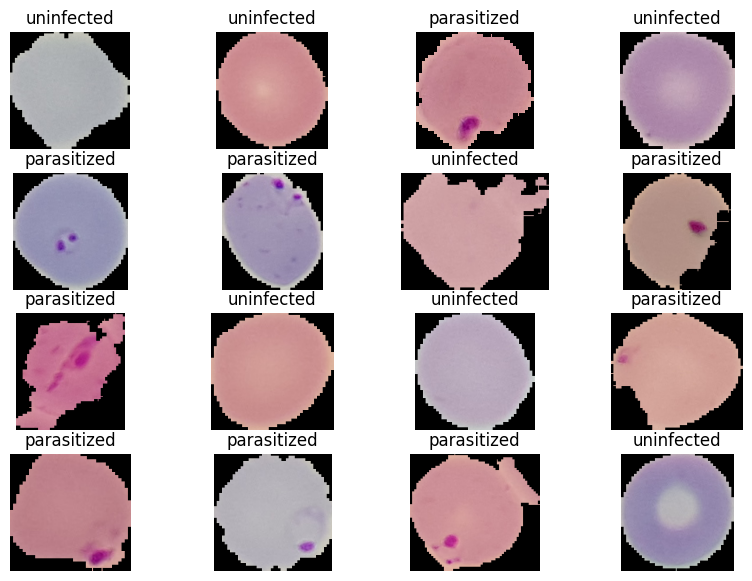

In [12]:
# Let's plot 16 images from our train_dataset
plt.figure(figsize = (10,7))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

## 3. Data Preprocessing

In [13]:
# Define a method to perform data resizing
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255., label

In [14]:
# By using the map function from the tf.data api, perform data preprocessing
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [15]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [16]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [17]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [18]:
# Trying to view the image tensor after normalization
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


## 4. Data Loading

In [19]:
# Prepare the data to be ready to load into the neaural network
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
# Prepare the data for the val_dataset
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [21]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [22]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## 5. Create the model


In [21]:
# Import the required libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, Dense, InputLayer, BatchNormalization, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

In [ ]:
# Create the model
model_1 = Sequential([

    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6,
           kernel_size = 3,
           strides = 1,
           padding = 'valid',
           activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2,
              strides = 2),

    Conv2D(filters = 16,
           kernel_size = 5,
           strides = 1,
           padding = 'valid',
           activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2,
              strides = 2),

    Flatten(),

    Dense(1000, activation = 'relu'),
    BatchNormalization(),
    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')
    ])

model_1.summary()

## 6. Compile the model


In [ ]:
# Compile the model
model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.01),
                metrics = ['accuracy'])

## 7. Fit the model

In [ ]:
# Fit the model
#hist_1 = model_1.fit(train_dataset, validation_data = val_dataset, epochs = 5, verbose = 1, callbacks = [tensorboard_callback])

In [ ]:
# Create a helper function to plot the loss curves of the model
def plot_loss_curves(history):
  """
  This function helps in plotting the loss and accuracy for both the training and validation sets.
  """
  # Let's fetch the loss values for both sets from the history
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Similary, get the accuracy for both the sets
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  # Let's find the number of epochs
  epochs = range(len(history.history['loss']))

  # Now that we have the values, let's plot them
  plt.plot(epochs, loss, label = 'Training Loss')
  plt.plot(epochs, val_loss, label = 'Validation Loss')
  plt.title('Training Vs. Validation Loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label = 'Training Accuracy')
  plt.plot(epochs, val_accuracy, label = 'Validation Accuracy')
  plt.title('Training Vs. Validation Accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend();

In [ ]:
load_model = tf.keras.models.load_model('/content/drive/MyDrive/TENSORFLOW_2.0/Malaria_Detection_Model')

OSError: No file or directory found at /content/drive/MyDrive/TENSORFLOW_2.0/Malaria_Detection_Model

In [ ]:
# Plot the loss curves
#plot_loss_curves(hist_1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## 8. Evaluate the model


In [ ]:
# Checking the train dataset for the shape
train_dataset

In [ ]:
# check the test dataset for shape
test_dataset

Since, we did the batching for the train dataset, the shape of train_dataset has been changed to (None, 224, 224, 3). In order to evaluate our model we need to perform the batching for our test_dataset as well.

In [ ]:
# Let's create the batch for our test_dataset as well and view it
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# Evaluate the model on the test dataset
load_model.evaluate(test_dataset.take(1))

1/1 [==============================] - 16s 16s/step - loss: 0.0259 - accuracy: 1.0000


[0.025904756039381027, 1.0]

In [ ]:
# Create a function to classify the output 0 : Parasitized, 1 : Uninfected
def parasitized_or_not(input_value):
  if (input_value < 0.5):
    return 'Parasitized'
  else:
    return 'Uninfected'

In [ ]:
print(type(test_dataset))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


1/1 [==============================] - 0s 26ms/step


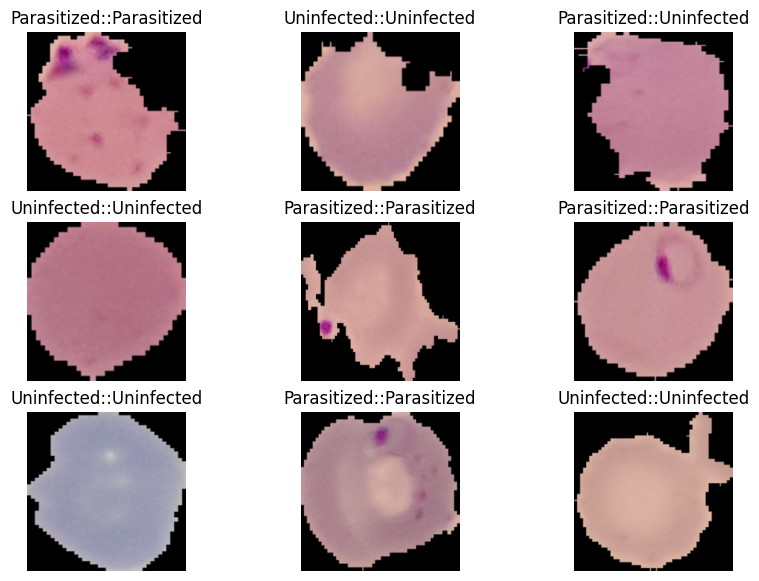

In [ ]:
# Let's make prediction on randome images of the test_dataset and view it
plt.figure(figsize = (10,7))
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasitized_or_not(label.numpy()[0])) + "::" + (str(parasitized_or_not(load_model.predict(image)[0][0]))))
  plt.axis(False)

## 9. Save the model

In [ ]:
#model_1.save("Malaria_Detection_Model.hdf5")

In [ ]:
#!cp -r /content/Malaria_Detection_Model /content/drive/MyDrive/TENSORFLOW_2.0

# A Different way of creating the models

Untill now we have seen how to create the models in tensorflow using the sequential API.  Now, we will see what other API's can be used to create models in tensorflow.

1. Sequential API
2. Functional API
3. Subclasses API

## 1. Let's create the model using Functional API

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, Dense, InputLayer, BatchNormalization, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

In [ ]:
# Creating the model using the functional API
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

In [ ]:
# Create the instance of the Input class
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'input image')

# Build the model

x = Conv2D(6, 3, activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(2)(x)

x = Conv2D(16, 3, activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(2)(x)
# Layers above this point are used for feature extraction
# Below layers are responsible for classication
x = Dense(1000, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)


# Output layer
func_output = Dense(1, activation = 'sigmoid')(x)

model_2 = Model(func_input, func_output, name = 'Functional_MODEL')
model_2.summary()

### The above model can be created in the below manner

#### 1. Feature Extractor

In [ ]:
# Create the instance of the Input class
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'input image')

# Build the model

x = Conv2D(6, 3, activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(2)(x)

x = Conv2D(16, 3, activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(2)(x)

feature_extractor = Model(func_input, output, name = 'Feature_Extractor')
feature_extractor.summary()

#### 2. Classifier

In [ ]:
# classification happens from here
x = feature_extractor(func_input)
x = Dense(1000, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)


# Output layer
func_output = Dense(1, activation = 'sigmoid')(x)

model_2 = Model(func_input, func_output, name = 'Functional_MODEL')
model_2.summary()

## 2. Creating the model using the Model Subclassing method

In [ ]:
# Define a feature extractor using the model subclasses method
from tensorflow.keras.layers import Layer
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()
    self.conv_1 = Conv2D(filters= filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = pool_size, strides = strides)
    self.conv_2 = Conv2D(filters= filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size = pool_size, strides = strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(filters = 8, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu', pool_size = 2)

In [ ]:
# Let's create the model for the feature extractor we built in the above cell
class model_3(Model):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(model_3, self).__init__()

    self.feature_extractor = FeatureExtractor(filters = 8, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu', pool_size = 2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation = 'relu')
    self.batch_1 = BatchNormalization()
    self.dense_2 = Dense(10, activation = 'relu')
    self.batch_2 = BatchNormalization()
    self.dense_3 = Dense(1, activation = 'sigmoid')

  def call(self, x, training):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

model_3_subclassed = model_3(filters = 8, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu', pool_size = 2)
model_3_subclassed(tf.zeros([1, 224, 224, 3]))
model_3_subclassed.summary()

In [ ]:
# we can noe compile and fit the model
model_3_subclassed.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
#hist_3 = model_3_subclassed.fit(train_dataset, validation_data = val_dataset, epochs = 5, verbose = 1)

## 3. Creating custom Dense layers for Neural networks

The value input_features_shape represents the shape of the input features that are passed to the layer. This value is automatically intercepted and passed to the build() method of the layer when the layer is built within a TensorFlow model.

Here's how it works:

**During Model Building:**

* When you create a model in TensorFlow and add layers to it, TensorFlow internally manages the flow of data and shapes.
* When a layer is added to the model, TensorFlow doesn't immediately allocate memory for its weights and biases. Instead, it waits until the model receives its first batch of data to infer the shapes of the input features and to build the layer dynamically.

**Intercepting input_features_shape:**

* The input_features_shape is a tuple representing the shape of the input features.
* This tuple contains information about the dimensions of the input data. For example, for a 2D input (e.g., images), it would be (batch_size, height, width, channels).
* The -1 indexing (input_features_shape[-1]) is used to extract the size of the last dimension, which typically corresponds to the number of features or channels in the input data.

**Usage in the build() Method:**

* In the build() method of the layer, input_features_shape is used to determine the shape of the weights (self.w) based on the number of input features.
* By intercepting input_features_shape, we ensure that the layer can adapt its internal structure (such as weights and biases) based on the shape of the input data it receives during model execution.
* In summary, TensorFlow automatically passes the shape of the input features to the layer's build() method when the model is built, allowing the layer to initialize its weights and biases appropriately based on the input data's shape.








In [ ]:
# We are writing our own custom Dense layer
class CustomLayerDense(Layer):
  def __init__(self, output_units, activation):
    # super(CustomLayerDense, self).__init__() calls the constructor of the superclass (Layer) to properly initialize the layer.
    super(CustomLayerDense, self).__init__()
    # self.output_units and self.activation store the number of output units (neurons) and the activation function to be used, respectively.
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    # We call the self.add_weight from the Layer class we inherit.
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = 'random_normal', trainable = True)
    # We initialize weights and biases randomly ('random_normal'), and we specify their shapes based on the input features and output units.
    self.b = self.add_weight(shape = (self.output_units,), initializer = 'random_normal', trainable = True)

  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b
    if (self.activation =='relu'):
      return tf.nn.relu(pre_output)

    elif (self.activation =='sigmoid'):
      return tf.math.sigmoid(pre_output)

    else:
      return pre_output

In [ ]:
# Create the model and use the custom Dense layer in the model building
model_4 = Sequential([

    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6,
           kernel_size = 3,
           strides = 1,
           padding = 'valid',
           activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2,
              strides = 2),

    Conv2D(filters = 16,
           kernel_size = 5,
           strides = 1,
           padding = 'valid',
           activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2,
              strides = 2),

    Flatten(),

    CustomLayerDense(1000, activation = 'relu'),
    BatchNormalization(),
    CustomLayerDense(100, activation = 'relu'),
    BatchNormalization(),
    CustomLayerDense(1, activation = 'sigmoid')
    ])

model_4.summary()

In [ ]:
model_4.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
#hist_4 = model_4.fit(train_dataset, validation_data = val_dataset, epochs = 5, verbose = 1)

## 4. Using different Metrics for Evaluating the model

In [ ]:
# Let's import the different evaluation metrics
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, Accuracy, TruePositives, TrueNegatives, Precision, Recall, AUC

In [ ]:
# Create the list of all metrics and pass it into the model
metrics = [BinaryAccuracy(name='Accuracy'), FalsePositives(name = 'fp'), FalseNegatives(name = 'fn'), TruePositives(name = 'tp'), TrueNegatives(name = 'tn'), Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc')]

In [ ]:
# Fit the model to run the metrics onthe model
model_1.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics = metrics)
history_5 = model_1.fit(train_dataset, validation_data = val_dataset, epochs = 5, verbose = True, callbacks = [LossCallback()])

### Building Confusion matrix

In [ ]:
# importing necessary libraries
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
len(test_dataset)

In [ ]:
labels =[]
inp = []
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(labels)
#labels = np.array([i[0] for i in labels])
print(labels)

[0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 

In [ ]:
len(labels)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

In [ ]:
predicted = load_model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

In [ ]:
len(predicted)

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix - {}'.format(threshold))
plt.xlabel('Predicted')
plt.ylabel('Actual')



In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
len(fp), len(tp), len(thresholds)

In [ ]:
plt.figure(figsize = (10,10))
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip =20
for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()

# Creating the callbacks

Until now we have been using the history callback present in `tf.keras.callbacks.History`. The way we were creating this is by calling the `model.fit()` function and assigning the output to history variable. With the help of this variable we were able to create the loss curves and accuracy plots.

We can also create our own callbacks using the `tf.keras.callbacks.callback`. So, let's try creating our own callback for the loss.

## Custom CallBacks

In [ ]:
# Creating the callback
from tensorflow.keras.callbacks import Callback

# Define a class for the custom callback
class LossCallback(Callback):
  # This callback prints the loss at every epoch
  def on_epoch_end(self, epoch, logs):
    print('For Epoch Number {} the model has a loss of {}.'.format(epoch + 1, logs['loss']))

  def on_batch_end(self, batch, logs):
    print("For Batch Number {} the model has loss of {}.".format(batch + 1, logs))

## CSVLogger

In this method we log all of the events in a csv.


In [ ]:
from tensorflow.keras.callbacks import CSVLogger
csv_log = CSVLogger(
    'log.csv', separator = ',', append = True
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor = 'loss', min_delta = 0, patience = 2, mode = 'auto'
)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
def schedule(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return tf.math.exp(-0.1) * lr

scheduler = LearningRateScheduler(schedule, verbose = 1)

## Data Augmentation using the `tf.data`

In [ ]:
# Creating the data performant pipelines using the tf.data.dataset
train_dataset_1 = (train_dataset
                   .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
                   .map (resize_rescale)
                   .batch(32)
                   .prefetch(tf.data.AUTOTUNE))

In [ ]:
# Let's define a function for the data augmentation which performs rotation, adjust saturation levels, flip images right left
def augment(image, label):
  image, label = resize_rescale(image, label)
  image = tf.image.rot90(image)
  image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)

Compile and run themodel

## Data Augmentation techniques

### Data augmentation using the Keras Layers

In [ ]:
from tensorflow.keras.layers import RandomRotation, RandomFlip, Resizing, Rescaling

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(224,224),
    Rescaling(1.0/255)])

In [ ]:
augment_layers = tf.keras.Sequential([
    RandomFlip(mode = 'horizontal'),
    RandomRotation(factor= (0.25, 0.2501))
])

def augment_layers(image, labels):
  return augment_layers(image), labels

In [ ]:
28.360000000000007/ 13.27


In [ ]:
from scipy import stats

# Sample data
sample1 = [9, 11, 10, 11, 10, 12, 9, 11, 12, 9, 10]
sample2 = [10, 13, 10, 13, 12, 9, 11, 12, 12, 12, 13]

# Perform a two-sample t-test for independent samples
t_statistic, p_value = stats.ttest_ind(sample1, sample2, equal_var=True)

# Print the p-value
print("p-value:", p_value)

In [ ]:
train_dataset_1 = (train_dataset
                   .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
                   .map (augment_layers)
                   .batch(32)
                   .prefetch(tf.data.AUTOTUNE))

Compile and run the model

## Including the augmentation and resizing in the model

In [ ]:
train_dataset_1 = (train_dataset
                   .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
                   .batch(32)
                   .prefetch(tf.data.AUTOTUNE))

In [ ]:
 # Create the model
model_5 = tf.keras.Sequential([

    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    resize_rescale_layers, # Resizing
    augment_layers, # Image augmentations
    Conv2D(filters = 6,
           kernel_size = 3,
           strides = 1,
           padding = 'valid',
           activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2,
              strides = 2),

    Conv2D(filters = 16,
           kernel_size = 5,
           strides = 1,
           padding = 'valid',
           activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2,
              strides = 2),

    Flatten(),

    Dense(1000, activation = 'relu'),
    BatchNormalization(),
    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')
    ])

model_5.summary()

Compile and run the model

In [ ]:
!wget https://github.com/krutika-shimpi/MyRepository/raw/main/cat.PNG
!wget https://github.com/krutika-shimpi/MyRepository/raw/main/dog1.PNG

--2024-04-07 09:57:46--  https://github.com/krutika-shimpi/MyRepository/raw/main/cat.PNG
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/krutika-shimpi/MyRepository/main/cat.PNG [following]
--2024-04-07 09:57:46--  https://raw.githubusercontent.com/krutika-shimpi/MyRepository/main/cat.PNG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195832 (191K) [image/png]
Saving to: ‘cat.PNG’

cat.PNG             100%[===================>] 191.24K  --.-KB/s    in 0.01s   

2024-04-07 09:57:46 (13.9 MB/s) - ‘cat.PNG’ saved [195832/195832]

--2024-04-07 09:57:46--  https://github.com/krutika-shimpi/MyReposit

## Using Computer vision

In [ ]:

image = cv2.imread('/content/cat.PNG')
image = resize_rescale(image, 'cat')
#image[0].shape
image = tf.expand_dims(image[0], axis = 0)
load_model.predict(image)

In [ ]:
class Rot_90(Layer):
  def __init__(self):
    super().__init__()

  def call(self, image):
    return tf.image.rot90(image, tf.random.uniform(shape = [], minval = 0, maxval = 2. dtype =tf.int32))

In [ ]:
@tf.function
def augment(image, label):
  image, label = resize_rescale(image, label)
  image = tf.image.rot90(image, k = tf.random.uniform(shape = [], minval = 0, maxval = 2. dtype =tf.int32))
  #image = tf.image.stateless_random_saturation(image, 0.3, 0.5)
  image = tf.image.ramdom_flip_left_right(image)

  return image, label

In [ ]:
augment_layers = tf.keras.Sequential([
    RandomFlip(mode = 'horizontal'),
    # RandomRotation(factor= (0.25, 0.2501))
    Rot_90()
])

def augment_layers(image, labels):
  return augment_layers(image, training = True), labels

## Data Augmentation using the @tf.function decorator

### Mixup Data Augmentations

The Beta distribution in statistics:

**Definition:** A continuous probability distribution defined by two positive parameters, often used to model uncertainty about the probability of success of an experiment.

**Use cases:**

* **Bayesian inference:** It serves as the conjugate prior probability distribution for Bernoulli, binomial, negative binomial, and geometric distributions.

* **Modeling probabilities:** It's employed to model probabilities and the behavior of proportions or percentages.

* **Random variables**: It models random variables within a finite interval.

**Properties:**

1. Continuous distribution.
2. Parameters determine the shape and spread of the distribution.
3. Versatile in modeling various scenarios involving probabilities.

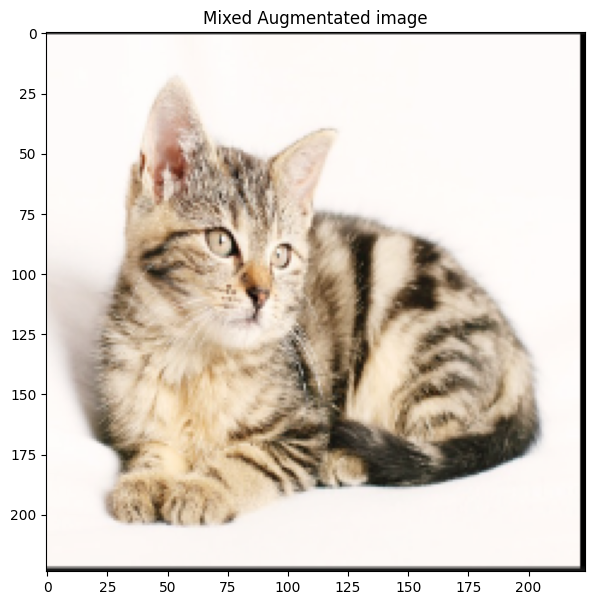

In [ ]:
# Import the tensorflow probability
import tensorflow_probability as tfp
import cv2
IM_SIZE = 224

# Lets read the images using Open cv
image_1 = cv2.resize(cv2.imread('cat.PNG'), (IM_SIZE, IM_SIZE))
image_2 = cv2.resize(cv2.imread('dog1.PNG'), (IM_SIZE, IM_SIZE))
image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2_rgb = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

label_1 = 0
label_2 = 1

# Set up the beta distribution
lamda = tfp.distributions.Beta(0.2, 0.2)
lamda = lamda.sample(1)[0]

# Mixup the two images and their labels
image = lamda * image_1_rgb + (1-lamda) * image_2_rgb
label = lamda * label_1 + (1-lamda) * label_2

# Plot the image
plt.figure(figsize = (10, 7))
plt.imshow(image/255)
plt.title('Mixed Augmentated image')
plt.show()

In [ ]:
# Create a mixed dataset using the training dataset and resize it to avoid shape errors
train_dataset_1 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)

# Zip both datasets
mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

Lets convert the above mixup into a function to setup in our code..

In [ ]:
# Define a function to incorporate mixup augementations in our code
def mixup_augmentation(train_dataset_1, train_dataset_2):
  IM_SIZE = 224

  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  # Set up the beta distribution
  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]

  # Mixup the two images and their labels
  image = lamda * image_1 + (1-lamda) * image_2
  label = lamda * tf.cast(label_1, dtype = tf.float32) + (1-lamda) * tf.cast(label_2, dtype = tf.float32)

  return image, label

In [ ]:
BATCH_SIZE = 32
mixed_train_dataset = (mixed_dataset
                      .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
                      .map(mixup_augmentation)
                      .prefetch(tf.data.AUTOTUNE)
                      )

mixed_val_dataset = (mixed_dataset
                    .map(mixup_augmentation)
                    .prefetch(tf.data.AUTOTUNE)
                    )

In [ ]:
mixed_train_dataset, mixed_val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

Go ahead and build the model using the mixed dataset

### Cutmix data augmentations

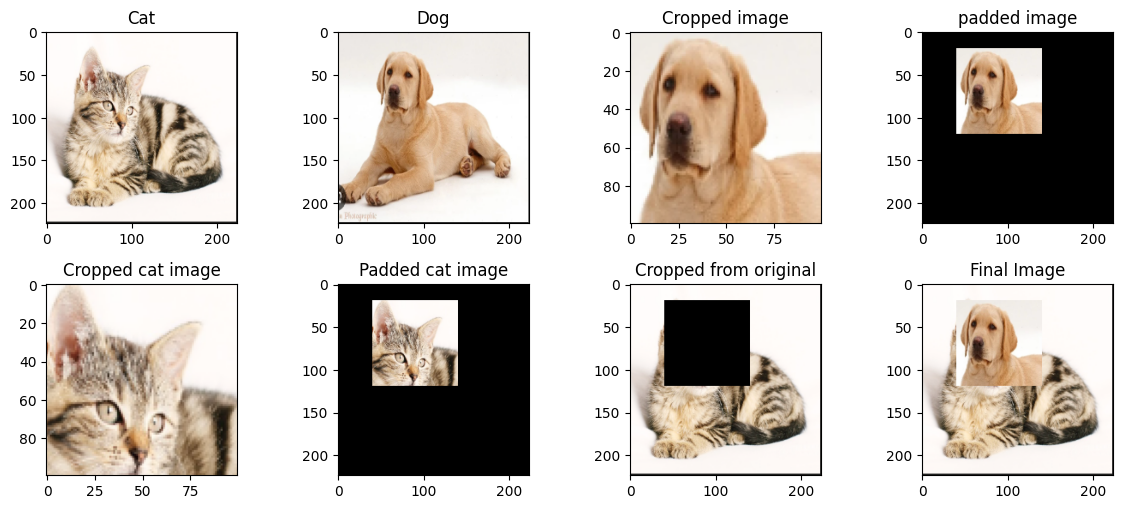

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Read the images and resize them
img_1 = cv2.resize(cv2.imread('cat.PNG'), (IM_SIZE, IM_SIZE))
img_2 = cv2.resize(cv2.imread('dog1.PNG'), (IM_SIZE, IM_SIZE))

# Convert BGR images to RGB format
img_1_rgb = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
img_2_rgb = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

# Plot the images
plt.figure(figsize=(12, 10))
plt.subplot(4, 4, 1)
plt.imshow(img_1_rgb)
plt.title('Cat')

plt.subplot(4, 4, 2)
plt.imshow(img_2_rgb)
plt.title('Dog')

# Cut a piece of the image using the crop_to_bounding_box function
crop_dog = tf.image.crop_to_bounding_box(img_2_rgb, 20, 40, 100, 100)

plt.subplot(4, 4, 3)
plt.imshow(crop_dog)
plt.title('Cropped image')

# Pad the image with zeroes for the specified height and width
image_4 = tf.image.pad_to_bounding_box(crop_dog, 20, 40, IM_SIZE, IM_SIZE)

plt.subplot(4, 4, 4)
plt.imshow(image_4)
plt.title('padded image')

# Crop the same portion from the cat image
crop_cat = tf.image.crop_to_bounding_box(img_1_rgb, 20, 40, 100, 100)

plt.subplot(4, 4, 5)
plt.imshow(crop_cat)
plt.title('Cropped cat image')

# Pad the image of the cropped cat
pad_cat = tf.image.pad_to_bounding_box(crop_cat, 20, 40, IM_SIZE, IM_SIZE)

plt.subplot(4, 4, 6)
plt.imshow(pad_cat)
plt.title('Padded cat image')

# Image_5: We want to subtract the cropped portion of cat from the whole cat image
image_5 = img_1_rgb - pad_cat
plt.subplot(4, 4, 7)
plt.imshow(image_5)
plt.title('Cropped from original')

# Image 6: Add the previously cropped portion of the second image to first
plt.subplot(4, 4, 8)
image_6 = image_4 + image_5
plt.imshow(image_6)
plt.title('Final Image')
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow_probability as tfp
def calculate_offset(lamda):
  IM_SIZE = 224

  # Take samples from the Uniform distributions
  rx = tf.cast(tfp.distributions.Uniform(low = 0, high = IM_SIZE).sample(1)[0], dtype = tf.int32)
  ry = tf.cast(tfp.distributions.Uniform(low = 0, high = IM_SIZE).sample(1)[0], dtype = tf.int32)

  # Setup the height and width of the image
  rw = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype = tf.int32)
  rh = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype = tf.int32)

  # Fetch the lengths of offset corners of the crop size, The values sometime
  # end up being negative which causes the box to move out of the image bounding.
  # Therefore, we restrict it to the bounding box of the image
  rx = tf.clip_by_value(rx - rw//2, 0 , IM_SIZE)
  ry = tf.clip_by_value(ry - rh//2, 0 , IM_SIZE)

  xbr = tf.clip_by_value(rx - rw//2, 0 , IM_SIZE)
  ybr = tf.clip_by_value(ry - rh//2, 0 , IM_SIZE)

  rw = xbr - rx
  if rw == 0:
    rw = 1

  rh = ybr - ry
  if rh == 0:
    rh = 1

  return ry, rx, rh, rw

In [ ]:
# Now that we have this working we can create a function out of this
def cutmix_augmentation(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  # Take random samples from the beta distributions
  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]

  ry, rx, rh, rw = calculate_offset(lamda)

  crop_2 = tf.image.crop_to_bounding_box(image_2, ry, rx, rh, rw)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, ry, rx, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, ry, rx, rh, rw)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, ry, rx, IM_SIZE, IM_SIZE)

  image = image_1 - pad_1 + pad_2
  lamda = tf.cast(1 - (rw * rh) / (IM_SIZE * IM_SIZE), dtype = tf.float32)
  label = lamda * tf.cast(label_1, dtype = tf.float32) + (1-lamda) * tf.cast(label_2, dtype = tf.float32)

  return image, label

In [ ]:
BATCH_SIZE = 32
cutmixed_train_dataset = (mixed_dataset
                        .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
                        .map(cutmix_augmentation)
                        .prefetch(tf.data.AUTOTUNE)
                        )

cutmixed_val_dataset = (mixed_dataset
                      .map(cutmix_augmentation)
                      .prefetch(tf.data.AUTOTUNE)
                      )

In [ ]:
cutmixed_train_dataset, cutmixed_val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

### Albumentations


If you have small dataset use the probability values between 0.1 to 0.3

In [ ]:
import albumentations as A
transforms = A.Compose(
    [
      A.Resize(IM_SIZE, IM_SIZE),

      A.OneOf([A.HorizontalFlip(),
                A.VerticalFlip(),], p = 0.3),

      A.RandomRotate90(),
      #A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.2,
                                contrast_limit=0.2,
                                always_apply=False, p=0.5),
      #A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
      #A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
])

In [ ]:
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image, tf.float32)
  return image

In [ ]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

In [ ]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(process_data)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

NameError: name 'train_dataset' is not defined

## Experiment Tracking

### TensorBoard Callback


In [ ]:
!pip install -U tensorboard_plugin_profile
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = LOGS_DIR)

In [ ]:
%load_ext tensorboard

In [ ]:
hist_1 = model_1.fit(train_dataset, validation_data = val_dataset, epochs = 5, verbose = 1, callbacks = [tensorboard_callback])

In [ ]:
!gcloud auth

#### Different ways to view tensorboard data


In [ ]:
%tensorboard --logdir='./content/logs/'

In [ ]:
!kill 7863

In [ ]:
!lsof -i :6006

In [ ]:
from tensorboard import notebook
notebook.list()

In [ ]:
notebook.display(port = 6006, height = 1000)

In [ ]:
!tensorboard dev upload \
  --logdir '/content/logs'\
  --name "(My expriment)"\
  --one_shot

In [ ]:
import datetime as dt
CURRENT_TIME = dt.datetime.now().strftime('%d%m%y - %h%m%s')
METRIC_DIR = './logs/' + CURRENT_TIME + 'metrics/'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [ ]:
LOGS_DIR = './logs/' + CURRENT_TIME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = LOGS_DIR)

In [ ]:
def scheduler(epoch,lr):
  if epoch < 3:
    learning_rate = lr

  else:
    learning_rate = lr*tf.math.exp(-0.1)

  with train_writer.as_default():
    tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)

  return learning_rate

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
hist_1 = model_1.fit(train_dataset, validation_data = val_dataset, epochs = 2, verbose = 1, callbacks = [scheduler_callback, tensorboard_callback])

In [ ]:
#!rm -rf './logs'

#### Importing images to tensorboard

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
# importing necessary libraries
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix
import datetime as dt
import io
import os
from tensorflow.keras.callbacks import Callback

class LogImagesCallbackTensorBoard(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = model_1.predict(np.array(inp)[:,0,...])

    threshold = 0.5

    cm = confusion_matrix(labels, predicted > threshold)

    plt.figure(figsize=(8,8))

    sns.heatmap(cm, annot=True,)
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format = 'png')

    image = tf.image.decode_png(buffer.getvalue(), channels=3)
    image = tf.expand_dims(image, axis = 0)

    CURRENT_TIME = dt.datetime.now().strftime('%d%m%y - %h%m%s')
    IMAGE_DIR = './logs/' + CURRENT_TIME + '/images'
    image_writer = tf.summary.create_file_writer(IMAGE_DIR)

    with image_writer.as_default():
      tf.summary.image("Training data", image, step = epoch)

In [ ]:
# Compile the model
model_1.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics = ['accuracy'])

In [ ]:
hist_1 = model_1.fit(train_dataset, validation_data = val_dataset, epochs = 2, verbose = 1, callbacks = [scheduler_callback, tensorboard_callback, LogImagesCallbackTensorBoard()])

NameError: name 'model_1' is not defined

### Wandb Install and Login

In [23]:
!pip install wandb

In [23]:
from tensorflow.keras.callbacks import Callback

class LogImagesCallbackWandb(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x, y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)

    labels = np.array([i[0] for i in labels])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])

    pred = []

    for i in range(len(predicted)):
      if(predicted[i][0] < 0.5):
        pred.append([1,0])
      else:
        pred.append([0,1])

    pred = np.array(pred)

    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs = pred,
                                                        y_true = labels,
                                                        class_names = ['Parasitized', 'Uninfected'])})


In [24]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [25]:
# Importing wandb
import wandb
from wandb.keras import WandbCallback

In [26]:
# Initialize the wandb by specifying the projects and entity
wandb.init(project = 'My_First_Project_Malaria_Detection')

wandb: Currently logged in as: krutikashimpi. Use `wandb login --relogin` to force relogin


In [27]:
# Let's configure the wandb to capture the metrics
wandb.config={
        "LEARNING_RATE": 0.001,
        "N_EPOCHS" : 3,
        "BATCH_SIZE" : 128,
        "DROPOUT_RATE" : 0.0,
        'IM_SIZE' : 224,
        'REGULARIZATION_RATE' : 0.0,
        "N_FILTERS" : 6,
        "KERNEL_SIZE" : 3,
        "POOL_SIZE" : 2,
        "N_DENSE_1" : 128,
        "N_DENSE_2" : 32,
        "N_STRIDES" : 1
}

configuration = wandb.config

In [28]:
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.layers import Dropout, Input, MaxPool2D, Conv2D, BatchNormalization, Dense, Flatten, InputLayer
from tensorflow.keras import Sequential

# Lets create the model, specify the wandb configurations and use them in building the model
configuration = wandb.config
IM_SIZE = configuration['IM_SIZE']
DROPOUT_RATE = configuration['DROPOUT_RATE']
REGULARIZATION_RATE = configuration['REGULARIZATION_RATE']
N_FILTERS = configuration['N_FILTERS']
KERNEL_SIZE = configuration['KERNEL_SIZE']
POOL_SIZE = configuration['POOL_SIZE']
N_STRIDES = configuration['N_STRIDES']

# Create the model
lenet_model = Sequential([

    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS,
           kernel_size = KERNEL_SIZE,
           strides = N_STRIDES,
           padding = 'valid',
           activation = 'relu',
           kernel_regularizer = L2(REGULARIZATION_RATE)),

    BatchNormalization(),

    MaxPool2D(pool_size = POOL_SIZE,
              strides = N_STRIDES * 2),

    Dropout(rate = DROPOUT_RATE),

    Conv2D(filters = N_FILTERS * 2 + 4,
           kernel_size = KERNEL_SIZE,
           strides = N_STRIDES,
           padding = 'valid',
           activation = 'relu',
           kernel_regularizer = L2(REGULARIZATION_RATE)),

    BatchNormalization(),

    MaxPool2D(pool_size = POOL_SIZE,
              strides = N_STRIDES * 2),

    Flatten(),

    Dense(configuration['N_DENSE_1'],
          activation = 'relu',
          kernel_regularizer = L2(REGULARIZATION_RATE)),

    BatchNormalization(),

    Dense(configuration['N_DENSE_2'],
          activation = 'relu',
          kernel_regularizer = L2(REGULARIZATION_RATE)),

    BatchNormalization(),

    Dense(1, activation = 'sigmoid')
    ])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      6

In [29]:
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
# Define the metrics
metrics = [TruePositives(name = 'tp'), FalsePositives(name = 'fp'), TrueNegatives(name = 'tn'), FalseNegatives(name = 'fn'),
           BinaryAccuracy(name = 'accuracy'), Precision(name = 'predicion'), Recall(name = 'recall'), AUC(name = 'auc')]

# Compile the model
lenet_model.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(configuration['LEARNING_RATE']),
                    metrics = metrics)

In [30]:
# Fit the model
lenet_history = lenet_model.fit(train_dataset,
                                epochs = 1,
                                validation_data = val_dataset,
                                verbose = 1,
                                callbacks = [WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
689/689 [==============================] - ETA: 0s - loss: 0.4220 - tp: 8869.0000 - fp: 2159.0000 - tn: 8864.0000 - fn: 2154.0000 - accuracy: 0.8044 - predicion: 0.8042 - recall: 0.8046 - auc: 0.8874

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240409_230849-3uydu46g/files/model-best)... Done. 0.2s


689/689 [==============================] - 76s 97ms/step - loss: 0.4220 - tp: 8869.0000 - fp: 2159.0000 - tn: 8864.0000 - fn: 2154.0000 - accuracy: 0.8044 - predicion: 0.8042 - recall: 0.8046 - auc: 0.8874 - val_loss: 0.3623 - val_tp: 1327.0000 - val_fp: 324.0000 - val_tn: 1038.0000 - val_fn: 66.0000 - val_accuracy: 0.8584 - val_predicion: 0.8038 - val_recall: 0.9526 - val_auc: 0.9526
Epoch 2/20
689/689 [==============================] - ETA: 0s - loss: 0.2218 - tp: 10252.0000 - fp: 1032.0000 - tn: 9989.0000 - fn: 773.0000 - accuracy: 0.9181 - predicion: 0.9085 - recall: 0.9299 - auc: 0.9679

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240409_230849-3uydu46g/files/model-best)... Done. 0.4s


689/689 [==============================] - 47s 68ms/step - loss: 0.2218 - tp: 10252.0000 - fp: 1032.0000 - tn: 9989.0000 - fn: 773.0000 - accuracy: 0.9181 - predicion: 0.9085 - recall: 0.9299 - auc: 0.9679 - val_loss: 0.2244 - val_tp: 1301.0000 - val_fp: 156.0000 - val_tn: 1207.0000 - val_fn: 91.0000 - val_accuracy: 0.9103 - val_predicion: 0.8929 - val_recall: 0.9346 - val_auc: 0.9692
Epoch 3/20
100/689 [===>..........................] - ETA: 36s - loss: 0.1788 - tp: 1560.0000 - fp: 128.0000 - tn: 1434.0000 - fn: 78.0000 - accuracy: 0.9356 - predicion: 0.9242 - recall: 0.9524 - auc: 0.9784

KeyboardInterrupt: 

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [31]:
# Wandb for validation data
from wandb.keras import WandbCallback
LABELS = ['Parasitized', 'Uninfected']
lenet_history = lenet_model.fit(train_dataset,
                                epochs = 1,
                                validation_data = val_dataset,
                                verbose = 1,
                                callbacks = [WandbCallback(labels = LABELS,
                                                           data_type = 'image',
                                                           log_evaluation=True,)])

wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.
wandb: WARNING WandbCallback is unable to read validation_data from trainer and therefore cannot log validation data. Ensure Keras is properly patched by calling `from wandb.keras import WandbCallback` at the top of your script.


689/689 [==============================] - ETA: 0s - loss: 0.1769 - tp: 10417.0000 - fp: 819.0000 - tn: 10205.0000 - fn: 605.0000 - accuracy: 0.9354 - predicion: 0.9271 - recall: 0.9451 - auc: 0.9790

wandb: WARNING No validation_data set, pass a generator to the callback.


689/689 [==============================] - 58s 84ms/step - loss: 0.1769 - tp: 10417.0000 - fp: 819.0000 - tn: 10205.0000 - fn: 605.0000 - accuracy: 0.9354 - predicion: 0.9271 - recall: 0.9451 - auc: 0.9790 - val_loss: 17.0220 - val_tp: 1394.0000 - val_fp: 1296.0000 - val_tn: 64.0000 - val_fn: 1.0000 - val_accuracy: 0.5292 - val_predicion: 0.5182 - val_recall: 0.9993 - val_auc: 0.5598


### Logging Images to WANDB

In [34]:
from tensorflow.keras.callbacks import Callback
import wandb

class LogImagesCallbackWandb(Callback):
    def __init__(self, test_dataset, batch_size=32):
        self.test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
        self.batch_size = batch_size

    def predict_on_dataset(self):
        predictions = []
        true_labels = []
        for x_batch, y_batch in self.test_dataset.as_numpy_iterator():
            predicted_batch = lenet_model.predict(x_batch)
            predictions.append(predicted_batch)
            true_labels.append(y_batch)
        return np.vstack(predictions), np.hstack(true_labels)

    def on_epoch_end(self, epoch, logs=None):
        predicted, true_labels = self.predict_on_dataset()

        pred = np.where(predicted < 0.5, [1, 0], [0, 1])

        wandb.log({
            "conf_mat": wandb.plot.confusion_matrix(probs=pred,
                                                      y_true=true_labels,
                                                      class_names=['Parasitized', 'Uninfected'])
        })
        wandb.log({
            "roc_curve": wandb.plot.roc_curve(y_probas=pred,
                                               y_true=true_labels,
                                               labels=['Parasitized', 'Uninfected'])
        })


# Assuming lenet_model is your model and test_dataset is your dataset
callback = LogImagesCallbackWandb(test_dataset)

# Train your model
lenet_history = lenet_model.fit(train_dataset,
                                epochs=2,
                                validation_data=val_dataset,
                                verbose=1,
                                callbacks=[callback])

Epoch 1/2
689/689 [==============================] - 75s 108ms/step - loss: 0.1573 - tp: 10509.0000 - fp: 734.0000 - tn: 10284.0000 - fn: 519.0000 - accuracy: 0.9432 - predicion: 0.9347 - recall: 0.9529 - auc: 0.9827 - val_loss: 0.2407 - val_tp: 1295.0000 - val_fp: 126.0000 - val_tn: 1231.0000 - val_fn: 103.0000 - val_accuracy: 0.9169 - val_predicion: 0.9113 - val_recall: 0.9263 - val_auc: 0.9569
Epoch 2/2
689/689 [==============================] - 66s 96ms/step - loss: 0.1291 - tp: 10590.0000 - fp: 574.0000 - tn: 10447.0000 - fn: 435.0000 - accuracy: 0.9542 - predicion: 0.9486 - recall: 0.9605 - auc: 0.9882 - val_loss: 0.1651 - val_tp: 1350.0000 - val_fp: 102.0000 - val_tn: 1258.0000 - val_fn: 45.0000 - val_accuracy: 0.9466 - val_predicion: 0.9298 - val_recall: 0.9677 - val_auc: 0.9818


In [35]:
class LogImagesCallbackWandbPlot(Callback):
    def __init__(self, test_dataset):
        self.test_dataset = test_dataset

    def on_epoch_end(self, epoch, logs=None):
        labels, predicted_probs = zip(*self.test_dataset.as_numpy_iterator())  # unpack data efficiently

        # Convert predicted probabilities to binary predictions using the threshold
        threshold = 0.5
        predicted_labels = [1 if pred < threshold else 0 for pred in predicted_probs]

        # Compute the confusion matrix
        cm = confusion_matrix(labels, predicted_labels)

        # Plot confusion matrix
        fig, ax = plt.subplots(figsize=(8, 8))
        sns.heatmap(cm, annot=True, ax=ax)
        ax.set_title('Confusion matrix - Epoch {}'.format(epoch))
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')
        ax.axis('off')

        # Save confusion matrix plot as an image and log it to WandB
        buffer = io.BytesIO()
        fig.savefig(buffer, format='png')
        plt.close(fig)  # Close the figure to release memory
        buffer.seek(0)
        image_array = tf.image.decode_png(buffer.getvalue(), channels=3)
        images = wandb.Image(image_array, caption='Confusion matrix for Epoch {}'.format(epoch))
        wandb.log({'Confusion Matrix': images})

# Assuming lenet_model is your model and test_dataset is your dataset
callback = LogImagesCallbackWandb(test_dataset)

# Train your model
lenet_history = lenet_model.fit(train_dataset,
                                epochs=2,
                                validation_data=val_dataset,
                                verbose=1,
                                callbacks=[callback])

Epoch 1/2
689/689 [==============================] - 68s 99ms/step - loss: 0.0910 - tp: 10719.0000 - fp: 416.0000 - tn: 10606.0000 - fn: 305.0000 - accuracy: 0.9673 - predicion: 0.9626 - recall: 0.9723 - auc: 0.9944 - val_loss: 0.2636 - val_tp: 1368.0000 - val_fp: 184.0000 - val_tn: 1177.0000 - val_fn: 26.0000 - val_accuracy: 0.9238 - val_predicion: 0.8814 - val_recall: 0.9813 - val_auc: 0.9734
Epoch 2/2
689/689 [==============================] - 67s 98ms/step - loss: 0.0837 - tp: 10734.0000 - fp: 365.0000 - tn: 10656.0000 - fn: 291.0000 - accuracy: 0.9702 - predicion: 0.9671 - recall: 0.9736 - auc: 0.9951 - val_loss: 0.1644 - val_tp: 1361.0000 - val_fp: 108.0000 - val_tn: 1256.0000 - val_fn: 30.0000 - val_accuracy: 0.9499 - val_predicion: 0.9265 - val_recall: 0.9784 - val_auc: 0.9832
